<H2>手書き文字認識を行うNeural Networkのレシピ</H2><br><H3>中原作成</H3>
ニューラルネットワークを使った画像認識のレシピです。今回はチュートリアルなどでよく使われている手書き文字データセットMNISTを学習してモデルを作成し、テスト画像を入力してその認識精度を確認します。

Chainer 4.5.0<BR>
CuPy 4.5.0<BR>
CUDA 9.2<BR>
  

<H2>環境のセットアップ（TSUBAMEでは不要？)</H2>

In [1]:
# Check GPU status
!nvidia-smi

Thu Oct 31 07:58:07 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# 旧バージョン向けにライブラリをインポート
### Install Chainer v5.2.0, Cupy v5.2.0 and CUDA
!curl https://colab.chainer.org/install | CHAINER_VERSION="==5.2.0" CUPY_VERSION="==5.2.0" sh -

<H3>必要なライブラリのインポート</H3>

In [0]:
# Import libraries
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
from chainer.dataset import concat_examples
from chainer.backends.cuda import to_cpu
import numpy as np

In [8]:
# Check environment
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)
import chainer
chainer.print_runtime_info()

GPU availability: True
cuDNN availablility: True
Platform: Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.4.0
NumPy: 1.17.3
CuPy:
  CuPy Version          : 5.4.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10010
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : 2402
  NCCL Runtime Version  : 2402
iDeep: 2.0.0.post3


<H3>ニューラルネットワークの定義</H3>

In [0]:
# Define Binary DNN (3-layers), note that, we use a mixed-precision (Binary + Float32) neural network
# To preserve a recognition accuracy. If you want learn more, see my FPGA'18 paper!
class MNIST(chainer.Chain):

    def __init__(self,n_mid_units=100,n_out=10):
        super(MNIST, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(784, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

<H3>ニューラルネットワークのパラメータと学習の設定</H3>

In [0]:
# Setup parameters
args_gpu=0 # 0: GPU (strongly recommendded), -1: CPU
args_unit=100 # The number of neurons in hidden layers
args_batchsize=100
args_epoch=3

<H3>定義したニューラルネットワークをメモリに読み込み、学習させる準備を行います。</H3>

In [11]:
# Printout parameters
print('GPU: {}'.format(args_gpu))
print('# unit: {}'.format(args_unit))
print('# Minibatch-size: {}'.format(args_batchsize))
print('# epoch: {}'.format(args_epoch))
print('')

# Set up a neural network to train
# Classifier reports softmax cross entropy loss and accuracy at every
# iteration, which will be used by the PrintReport extension below.
model = MNIST()
if args_gpu >= 0:
    # Make a specified GPU current
    chainer.backends.cuda.get_device_from_id(args_gpu).use()
    model.to_gpu()  # Copy the model to the GPU

# Setup an optimizer
optimizer = chainer.optimizers.Adam(alpha=0.0001)
optimizer.setup(model)

GPU: 0
# unit: 100
# Minibatch-size: 100
# epoch: 3



<H3>学習データであるMNISTデータセット(またはFashion MNIST)の読み込み。初回は多少時間がかかります。。</H3>

In [12]:
# Load the MNIST dataset
train, test = chainer.datasets.get_mnist() # handwritten character
#train, test = chainer.datasets.get_fashion_mnist() # fashion items

train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

<H3>MNISTデータの表示。このような画像を５万枚用いて学習します。認識精度のチェックには残り１万枚を用います。</H3>

<class 'chainer.datasets.tuple_dataset.TupleDataset'>


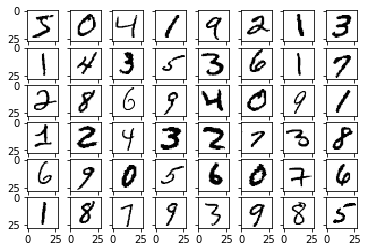

In [13]:
# Illustrate MNIST dataset
import matplotlib.pyplot as plt

print(type(train))
xtrain = train._datasets[0][:48]

fig,ax = plt.subplots(nrows=6,ncols=8,sharex=True,sharey=True)
ax = ax.flatten()
for i in range(48):
    img = xtrain[i].reshape(28,28)
    ax[i].imshow(img,cmap='Greys',interpolation='none')

<h3>ニューラルネットワークの学習を行います。GPUを用いて高速に学習ができます。</h3>

In [14]:
max_epoch = args_epoch

while train_iter.epoch < max_epoch:
    train_accuracies = []
    # ---------- One iteration of the training loop ----------
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch, args_gpu)

    # Calculate the prediction of the network
    prediction_train = model(image_train)

    # Calculate the loss with softmax_cross_entropy
    loss = F.softmax_cross_entropy(prediction_train, target_train)
    accuracy = F.accuracy(prediction_train, target_train)
    accuracy.to_cpu()
    train_accuracies.append(accuracy.data)
    # Calculate the gradients in the network
    model.cleargrads()
    loss.backward()

    # Update all the trainable parameters
    optimizer.update()
    # --------------------- until here ---------------------

    # Check the validation accuracy of prediction after every epoch
    if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

        # Display the training loss
        print('epoch:{:02d} train_loss:{:.04f} '.format(
                train_iter.epoch, float(to_cpu(loss.data))), end='')
        print('train_accuracy:{:.04f} '.format(
            np.mean(train_accuracies)),end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            image_test, target_test = concat_examples(test_batch, args_gpu)

            # Forward the test data
            prediction_test = model(image_test)

            # Calculate the loss
            loss_test = F.softmax_cross_entropy(prediction_test, target_test)
            test_losses.append(to_cpu(loss_test.data))

            # Calculate the accuracy
            accuracy = F.accuracy(prediction_test, target_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)

            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
                np.mean(test_losses), np.mean(test_accuracies)))

print("Done.")
chainer.serializers.save_npz('mnist.model',model)

epoch:01 train_loss:0.3819 train_accuracy:0.9000 val_loss:0.3834 val_accuracy:0.9010
epoch:02 train_loss:0.2052 train_accuracy:0.9400 val_loss:0.2814 val_accuracy:0.9222
epoch:03 train_loss:0.2489 train_accuracy:0.9500 val_loss:0.2409 val_accuracy:0.9319
Done.


<H3>学習したニューラルネットワークを使って認識できるかチェックしてみます。</H3>

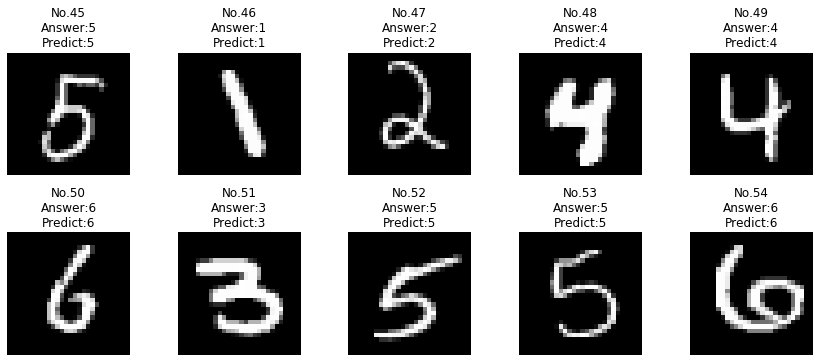

In [15]:

from chainer import Variable

def show_examples(model, test, device):
    plt.figure(figsize=(12,50))
#    if device < 0:
#        print("to cpu")
#        model.to_cpu()   test inpu
    model.to_cpu()
    for i in range(45, 55):
        data, label = test[i]  # test data, label
        x = Variable(np.asarray([data]))
        t = Variable(np.asarray([label]))  # labels
        y = model(x)
        prediction = y.data.argmax(axis=1)
        example = (data * 255).astype(np.int32).reshape(28, 28)
        plt.subplot(20, 5, i - 44)
        plt.imshow(example, cmap='gray')
        plt.title("No.{0}\nAnswer:{1}\nPredict:{2}".format(
            i,
            label,
            prediction[0]
        ))
        plt.axis("off")
    plt.tight_layout()

show_examples(model, test, args_gpu)